Possible pre-trained models: ResNet50, DenseNet121

In [1]:
import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import json
import time

from tensorflow.keras.applications import DenseNet121
import tensorflow as tf
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.applications import ResNet50
from keras.optimizers import SGD
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
import kagglehub
path = kagglehub.dataset_download("yasserhessein/dataset-alzheimer")
print("Path to dataset files:", path)

100%|██████████| 34.1M/34.1M [00:02<00:00, 13.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/yasserhessein/dataset-alzheimer/versions/1


In [3]:
hyperparameters = {
    'optimizer': {
        'type': 'rmsprop',
        'learning_rate': 0.001,
        'momentum': 0.9
    },
    'loss': 'categorical_crossentropy',
    'metrics': ['accuracy'],
    'epochs': 20,
    'validation_split': 0.2,
    'rotation_range': 0,
    'width_shift_range': 0,
    'height_shift_range': 0,
    'zoom_range': 0,
    'fill_mode': 'nearest',
    'batch_size': 32
}

In [4]:
# Splitting data / augmenting Data
device = "cuda" if torch.cuda.is_available() else "cpu"

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split=hyperparameters['validation_split'],
    rotation_range=hyperparameters['rotation_range'],
    width_shift_range=hyperparameters['width_shift_range'],
    height_shift_range=hyperparameters['height_shift_range'],
    zoom_range=hyperparameters['zoom_range'],
    fill_mode=hyperparameters['fill_mode']
)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [5]:
# building the train/val/test dataset
train_dataset  = train_datagen.flow_from_directory(
    directory = path + '/Alzheimer_s Dataset/train/',
    target_size = (224,224),
    class_mode = 'categorical',
    subset = 'training',
    batch_size=hyperparameters['batch_size'],
    shuffle = True
    )

valid_dataset  = train_datagen.flow_from_directory(
    directory = path + '/Alzheimer_s Dataset/train/',
    target_size = (224,224),
    class_mode = 'categorical',
    batch_size=hyperparameters['batch_size'],
    subset='validation',
    shuffle = False
    )

test_dataset = test_datagen.flow_from_directory(
    directory = path + '/Alzheimer_s Dataset/test/',
    target_size = (224,224),
    class_mode = 'categorical',
    batch_size=hyperparameters['batch_size'],
    shuffle = False
    )

Found 4098 images belonging to 4 classes.
Found 1023 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [6]:
img_labels = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

def display_images(dataset, title, num_images):
    class_images = {label: [] for label in img_labels}

    for images, labels in dataset:
        for i in range(len(images)):
            class_label = img_labels[labels[i].argmax()]
            if len(class_images[class_label]) < num_images:
                class_images[class_label].append(images[i])

            if all(len(class_images[label]) >= num_images for label in img_labels):
                break

        if all(len(class_images[label]) >= num_images for label in img_labels):
            break

    fig, axes = plt.subplots(len(img_labels), num_images, figsize=(15, 10))
    fig.suptitle(title, fontsize=16)

    for row, label in enumerate(img_labels):
        for col in range(num_images):
            if col < len(class_images[label]):
                axes[row, col].imshow(class_images[label][col])
                axes[row, col].axis('off')
                axes[row, col].set_title(f"Label: {label}")
            else:
                axes[row, col].axis('off')

    plt.show()

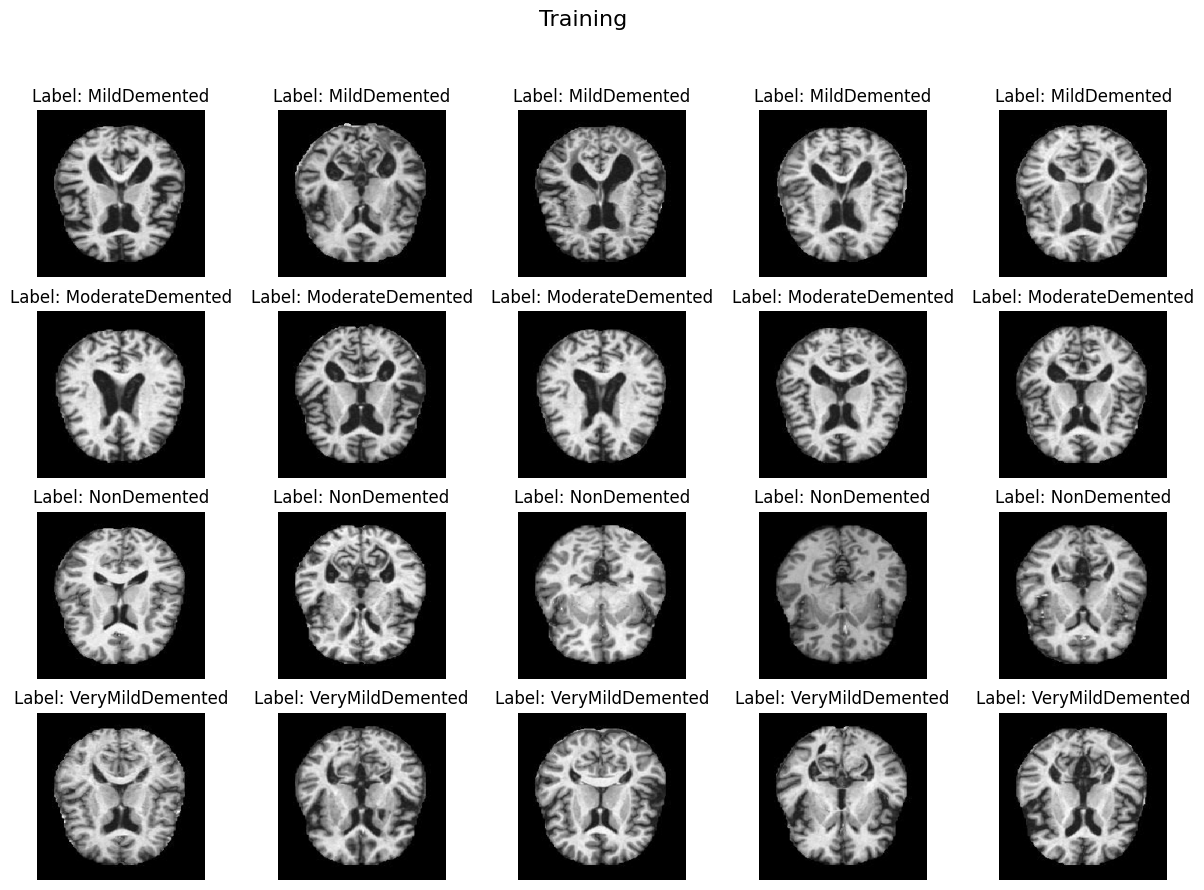

In [7]:
# Be mindful of augmentation of images
display_images(train_dataset, "Training", 5)

In [11]:
# Load the pretrained Model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add a custom NN ontop of the pretrained model
x = base_model.output
x = Flatten()(x)

x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Dense(32, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the Layers
for layer in model.layers:
    layer.trainable = False

# Unfreeze the top 4 layers
for layer in model.layers[-18:]:
    layer.trainable = True

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_4          │ (None, 230, 230, 3)    │              0 │ input_layer_2[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d_4[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_5          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_5[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 59,126,308 (225.55 MB)

 Trainable params: 703,524 (2.68 MB)

 Non-trainable params: 58,422,784 (222.87 MB)

In [12]:
optimizer = SGD(learning_rate=hyperparameters['optimizer']['learning_rate'],
                 momentum=hyperparameters['optimizer']['momentum'])

model.compile(optimizer='rmsprop',
              loss=hyperparameters['loss'],
              metrics=hyperparameters['metrics'])

history = model.fit(train_dataset,
                    validation_data=valid_dataset,
                    epochs=hyperparameters['epochs'])

Epoch 1/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 71s 353ms/step - accuracy: 0.3129 - loss: 1.7539 - val_accuracy: 0.4409 - val_loss: 1.3271
Epoch 2/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 39s 99ms/step - accuracy: 0.5485 - loss: 1.1305 - val_accuracy: 0.4370 - val_loss: 1.3573
Epoch 3/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - accuracy: 0.6582 - loss: 0.8609 - val_accuracy: 0.4585 - val_loss: 1.3319
Epoch 4/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 20s 101ms/step - accuracy: 0.6989 - loss: 0.7363 - val_accuracy: 0.4682 - val_loss: 1.3588
Epoch 5/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 21s 101ms/step - accuracy: 0.7414 - loss: 0.6534 - val_accuracy: 0.5386 - val_loss: 1.1569
Epoch 6/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - accuracy: 0.7672 - loss: 0.5983 - val_accuracy: 0.5562 - val_loss: 1.1475
Epoch 7/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 23s 120ms/step - accuracy: 0.7933 - loss: 0.5119 - val_accuracy: 0.5660 - val_loss: 1.1445
Epoch 8/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - accuracy: 0.8153 - loss: 0.

In [17]:
def Train_Val_Plot(acc, val_acc, loss, val_loss):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    fig.suptitle("MODEL'S METRICS VISUALIZATION")

    ax1.plot(range(1, len(acc) + 1), acc, label='Training Accuracy')
    ax1.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    ax2.plot(range(1, len(loss) + 1), loss, label='Training Loss')
    ax2.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.show()


In [14]:
def save_hyperparameters(hyperparameters, filename='hyperparameters.json'):
    with open(filename, 'w') as json_file:
        json.dump(hyperparameters, json_file, indent=4)

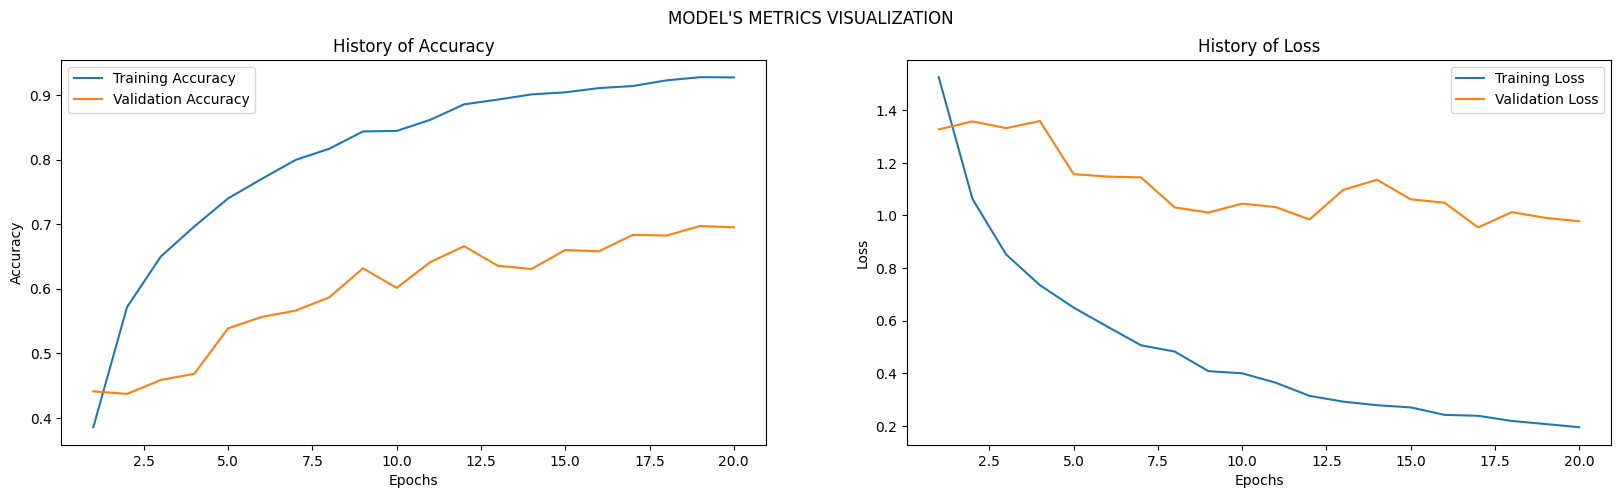

In [15]:
# Save Hyperparameters
save_hyperparameters(hyperparameters)

# Save Model
timestamp = time.strftime("%m/%d-%H:%M")
new_model_name = f'model_{timestamp}.h5'
model.save(new_model_name)

# Plot
Train_Val_Plot(history.history['accuracy'],
                history.history['val_accuracy'],
                history.history['loss'],
                history.history['val_loss'])

In [16]:
test_loss, test_accuracy = model.evaluate(test_dataset)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.6045 - loss: 1.5421
Test Loss: 1.2935
Test Accuracy: 0.6333
